Address the challenge of optimally placing products across warehouses for a business with high online sales, where accurate calculations are costly and only feasible biweekly. To speed up decision-making, an ML model approximates these results within hours. The model has four hyperparameters to tune, and its output reflects the difference from the expensive baseline. Because the system is dynamic and full of local optima, it requires careful tuning and robust validation to find reliable, near-optimal solutions.

optimzation to maximize

In [3]:
import numpy as np
import pandas as pd

In [4]:
inputs_f4 = np.load('function_4/initial_inputs.npy')
outputs_f4 = np.load('function_4/initial_outputs.npy')

In [5]:
print("Inputs (Function 4):", inputs_f4)

Inputs (Function 4): [[0.89698105 0.72562797 0.17540431 0.70169437]
 [0.8893564  0.49958786 0.53926886 0.50878344]
 [0.25094624 0.03369313 0.14538002 0.49493242]
 [0.34696206 0.0062504  0.76056361 0.61302356]
 [0.12487118 0.12977019 0.38440048 0.2870761 ]
 [0.80130271 0.50023109 0.70664456 0.19510284]
 [0.24770826 0.06044543 0.04218635 0.44132425]
 [0.74670224 0.7570915  0.36935306 0.20656628]
 [0.40066503 0.07257425 0.88676825 0.24384229]
 [0.6260706  0.58675126 0.43880578 0.77885769]
 [0.95713529 0.59764438 0.76611385 0.77620991]
 [0.73281243 0.14524998 0.47681272 0.13336573]
 [0.65511548 0.07239183 0.68715175 0.08151656]
 [0.21973443 0.83203134 0.48286416 0.08256923]
 [0.48859419 0.2119651  0.93917791 0.37619173]
 [0.16713049 0.87655456 0.21723954 0.95980098]
 [0.21691119 0.16608583 0.24137226 0.77006248]
 [0.38748784 0.80453226 0.75179548 0.72382744]
 [0.98562189 0.66693268 0.15678328 0.8565348 ]
 [0.03782483 0.66485335 0.16198218 0.25392378]
 [0.68348638 0.9027701  0.33541983 0.99

In [6]:
print("Outputs (Function 4):", outputs_f4)

Outputs (Function 4): [-22.10828779 -14.60139663 -11.69993246 -16.05376511 -10.06963343
 -15.48708254 -12.68168498 -16.02639977 -17.04923465 -12.74176599
 -27.31639636 -13.52764887 -16.6791152  -16.50715856 -17.81799934
 -26.56182083 -12.75832422 -19.44155762 -28.90327367 -13.70274694
 -29.4270914  -11.56574199 -26.85778644  -7.96677535  -6.70208925
 -32.62566022 -19.98949793  -4.02554228 -13.12278233 -23.1394284 ]


Best value 

In [7]:

idx_best = np.argmax(outputs_f4)
x_best = inputs_f4[idx_best]
y_best = outputs_f4[idx_best]

print("Best hyperparameter combination:", x_best)
print("Best output:", y_best)

Best hyperparameter combination: [0.57776561 0.42877174 0.42582587 0.24900741]
Best output: -4.025542281908162


Visualtize the plots 

Shows 2D projections of hyperparameters

Color = output value

Helps visually identify regions of high output

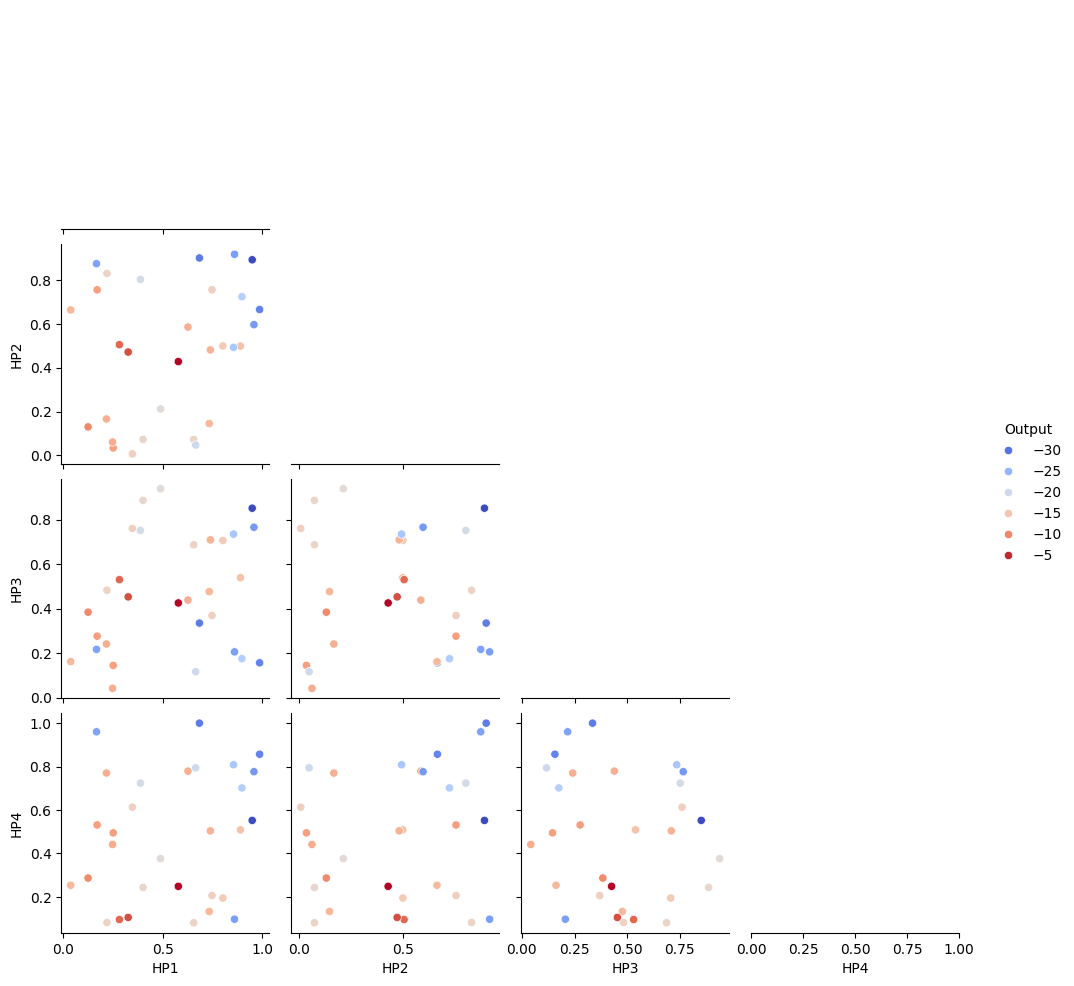

In [8]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(inputs_f4, columns=['HP1','HP2','HP3','HP4'])
df['Output'] = outputs_f4

sns.pairplot(df, hue='Output', palette='coolwarm', corner=True)

Fit the gaussian process

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2,1.0)) \
         + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6,1e0))

In [10]:
gp_f4 = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)

gp_f4.fit(inputs_f4, outputs_f4)
print("Optimized kernel:", gp_f4.kernel_)

Optimized kernel: 2.04**2 * RBF(length_scale=0.724) + WhiteKernel(noise_level=1e-06)


/opt/homebrew/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Step 3: Suggest the next point using UCB

Goal: maximize output (less negative)

In [11]:
num_candidates = 5000  # random sampling of 4D space
X_candidates = np.random.rand(num_candidates, 4)

mu, sigma = gp_f4.predict(X_candidates, return_std=True)

kappa = 2.5  # exploration/exploitation trade-off
UCB = mu + kappa * sigma

idx_next = np.argmax(UCB)
x_next = X_candidates[idx_next]

print("Next hyperparameter combination suggested by BO:", x_next)

Next hyperparameter combination suggested by BO: [0.38976138 0.33794909 0.34498475 0.40158546]


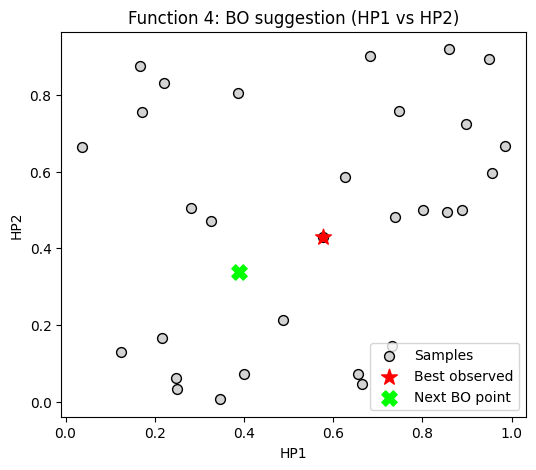

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(inputs_f4[:,0], inputs_f4[:,1], c='lightgray', s=50, edgecolors='black', label='Samples')
plt.scatter(x_best[0], x_best[1], c='red', s=140, marker='*', label='Best observed')
plt.scatter(x_next[0], x_next[1], c='lime', s=120, marker='X', label='Next BO point')
plt.xlabel('HP1')
plt.ylabel('HP2')
plt.title('Function 4: BO suggestion (HP1 vs HP2)')
plt.legend()
plt.show()